In [1]:
# Importing Relevant Libraries
import numpy as np
import math
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer, MinMaxScaler, VectorAssembler, StandardScaler
from pyspark.sql.types import *
from pyspark.sql.functions import col, udf
import numpy as np
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml.feature import *
from pyspark.sql.types import *
from pyspark.ml.linalg import *
from pyspark.sql.functions import *
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import PipelineModel
from pyspark.ml.stat import Correlation
import seaborn as sns
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
# File location and type
file_location = "./lish-moa/train_features.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
features_data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [3]:
# File location and type
file_location = "./lish-moa/train_targets_scored.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
targets_data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

### An interesting pattern in the gene expressions and cell viability values


In [4]:
features_df = features_data.toPandas()

/home/shashank/Desktop/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


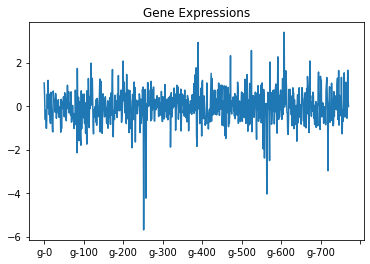

/home/shashank/Desktop/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


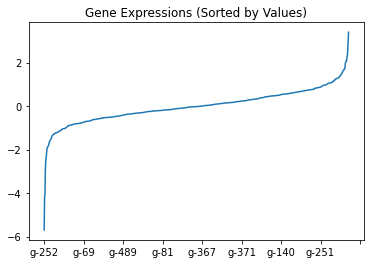

In [5]:
# Checking progression of gene_expressions values

# gene_expression values for 1st sample
features_df.iloc[0, 4:4+772].plot()
plt.title('Gene Expressions')
plt.show()

# Sorted gene_feature values for 1st sample
features_df.iloc[0, 4:4+772].sort_values().plot()
plt.title('Gene Expressions (Sorted by Values)')
plt.show()

/home/shashank/Desktop/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


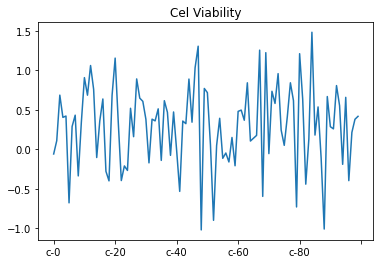

/home/shashank/Desktop/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


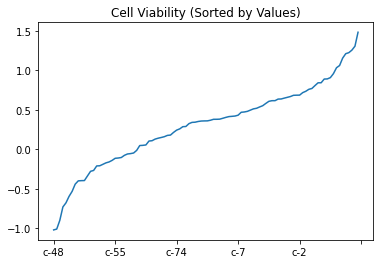

In [6]:
# Checking progression of cell viability values

# cell viability values for 1st sample
features_df.iloc[0, 4+772:].plot()
plt.title('Cel Viability')
plt.show()

# Sorted gene_feature values for 1st sample
features_df.iloc[0, 4+772:].sort_values().plot()
plt.title('Cell Viability (Sorted by Values)')
plt.show()

As can be seen from the above graphs, gene expression and cell viability data (when sorted by values) might be interpreted as some time series data (same pattern exists for all samples). This info is further used in feature selection part, wherein max and min values of gene expression and cell viability are added as features for every sample 

### Pre-Processing

In [5]:
# Dropping samples with cp_type = 'ctl_vehicle' (placebo group would have no activations in any MoAs) 
features_and_targets = features_data.join(targets_data, features_data.sig_id == targets_data.sig_id, how='inner').drop(targets_data.sig_id)
features_and_targets = features_and_targets.filter("cp_type = 'trt_cp'")

In [6]:
# One hot encoding cp_dose

# Indexing different categories in cp_type and storing in column 'cp_type_index'
string_indexer = StringIndexer(inputCol = 'cp_dose', outputCol = 'cp_dose_index')
features_and_targets = string_indexer.fit(features_and_targets).transform(features_and_targets).drop('cp_dose')

# One hot encoded and stored in cp_type_vector column
encoder = OneHotEncoder(inputCols=['cp_dose_index'],
                        outputCols=['cp_dose'], dropLast = False)

features_and_targets = encoder.fit(features_and_targets).transform(features_and_targets).drop('cp_dose_index')

In [7]:
# Label Encoding cp_time
assembler = VectorAssembler(inputCols = ['cp_time'], outputCol = 'cp_time_vector')
features_and_targets = assembler.transform(features_and_targets).drop('cp_time')

mm_scaler = MinMaxScaler(inputCol = 'cp_time_vector', outputCol = 'cp_time_scaled_vector', min = 0, max = 2)
features_and_targets = mm_scaler.fit(features_and_targets).transform(features_and_targets).drop('cp_time_vector')

firstElement=udf(lambda v:float(v[0]),FloatType())
features_and_targets = features_and_targets.withColumn('cp_time', firstElement(features_and_targets['cp_time_scaled_vector'])).drop('cp_time_scaled_vector')

### Stratified train-test split

In [8]:
'''
As our dataset is imbalanced, stratified train-test split was done so that test score is relevant. To perform stratified
split, I encoded all possible columns of target labels and then stratified was split was done based on the encoded value.
This ensures that, for every combination of target labels in the dataset, there are some samples both in train and test set
'''

# Encoding target labels' combination
def vector_to_string(a):
def vector_to_string(a):
  s=''
  for i in a:
    s = s + str(i) + ' '
  s.strip()
  return s
    
  
vector_to_string = udf(vector_to_string)   
spark.udf.register("vector_to_string", vector_to_string)

# Target columns names
target_names = []
for feature in targets_data.columns:
  if feature != 'sig_id':
    target_names.append(feature)
    
temp_df = features_and_targets.withColumn('target_vector', (vector_to_string(array([features_and_targets[col] for col in target_names])))).select(['sig_id', 'target_vector'])
string_indexer = StringIndexer(inputCol = 'target_vector', outputCol = 'target')
string_indexer_model = string_indexer.fit(temp_df)
temp_df = string_indexer_model.transform(temp_df).drop('target_vector')

data = features_and_targets.join(temp_df, features_and_targets.sig_id == temp_df.sig_id, how = 'inner').drop(temp_df.sig_id)

unique_targets = data.select('target').distinct().collect()

# Train-test split (80-20 split)
fraction = {}
split_ratio = 0.2
for row in unique_targets:
  fraction[row.target] = split_ratio
  
test_data = data.sampleBy('target', fractions=fraction, seed = 0)
data.createOrReplaceTempView('data_table')
test_data.createOrReplaceTempView('test_data_table')
train_data = spark.sql('select * from data_table as t1 where t1.sig_id not in (select t2.sig_id from test_data_table as t2)') 

# Asserting no data leakage
train_data.createOrReplaceTempView('train_data_table')
count = spark.sql('select * from train_data_table as t1 where t1.sig_id in (select t2.sig_id from test_data_table as t2)').count()
assert count == 0

train_data = train_data.drop('target')
test_data = test_data.drop('target')

In [9]:
gene_feature_names = [] # list containing gene expression names
cell_feature_names = [] # list containing cell viability names

for i in range(772):
  gene_feature_names.append('g-' + str(i))

for i in range(100):
  cell_feature_names.append('c-' + str(i))

other_feature_names = ['sig_id', 'cp_type', 'cp_time', 'cp_dose']

target_names = [col for col in train_data.columns if col not in gene_feature_names + cell_feature_names + other_feature_names]

### Feature Engineering

In [ ]:
# Engineering new features: max and min values for gene expression and cell viability data

max_gene_train_df = train_data.withColumn("gene_max", F.greatest(*gene_feature_names)).select('sig_id', 'gene_max')
min_gene_train_df = train_data.withColumn("gene_min", F.least(*gene_feature_names)).select('sig_id', 'gene_min')
max_cell_train_df = train_data.withColumn("cell_max", F.greatest(*cell_feature_names)).select('sig_id', 'cell_max')
min_cell_train_df = train_data.withColumn("cell_min", F.least(*cell_feature_names)).select('sig_id', 'cell_min')

max_gene_test_df = test_data.withColumn("gene_max", F.greatest(*gene_feature_names)).select('sig_id', 'gene_max')
min_gene_test_df = test_data.withColumn("gene_min", F.least(*gene_feature_names)).select('sig_id', 'gene_min')
max_cell_test_df = test_data.withColumn("cell_max", F.greatest(*cell_feature_names)).select('sig_id', 'cell_max')
min_cell_test_df = test_data.withColumn("cell_min", F.least(*cell_feature_names)).select('sig_id', 'cell_min')

### Feature Selection

In [10]:
# Finding Correlation among cont. gene expression and cell viability data to remove all redundant features

# Correlation among gene expressions and cell viability

cont_features = gene_feature_names + cell_feature_names
cont_features_df = train_data.select(cont_features)

va = VectorAssembler(inputCols = cont_features, outputCol = 'features')
cont_features_df = va.transform(cont_features_df)

corr_df = Correlation.corr(cont_features_df, 'features', 'pearson').collect()[0][0]

corr_mat = corr_df.toArray()


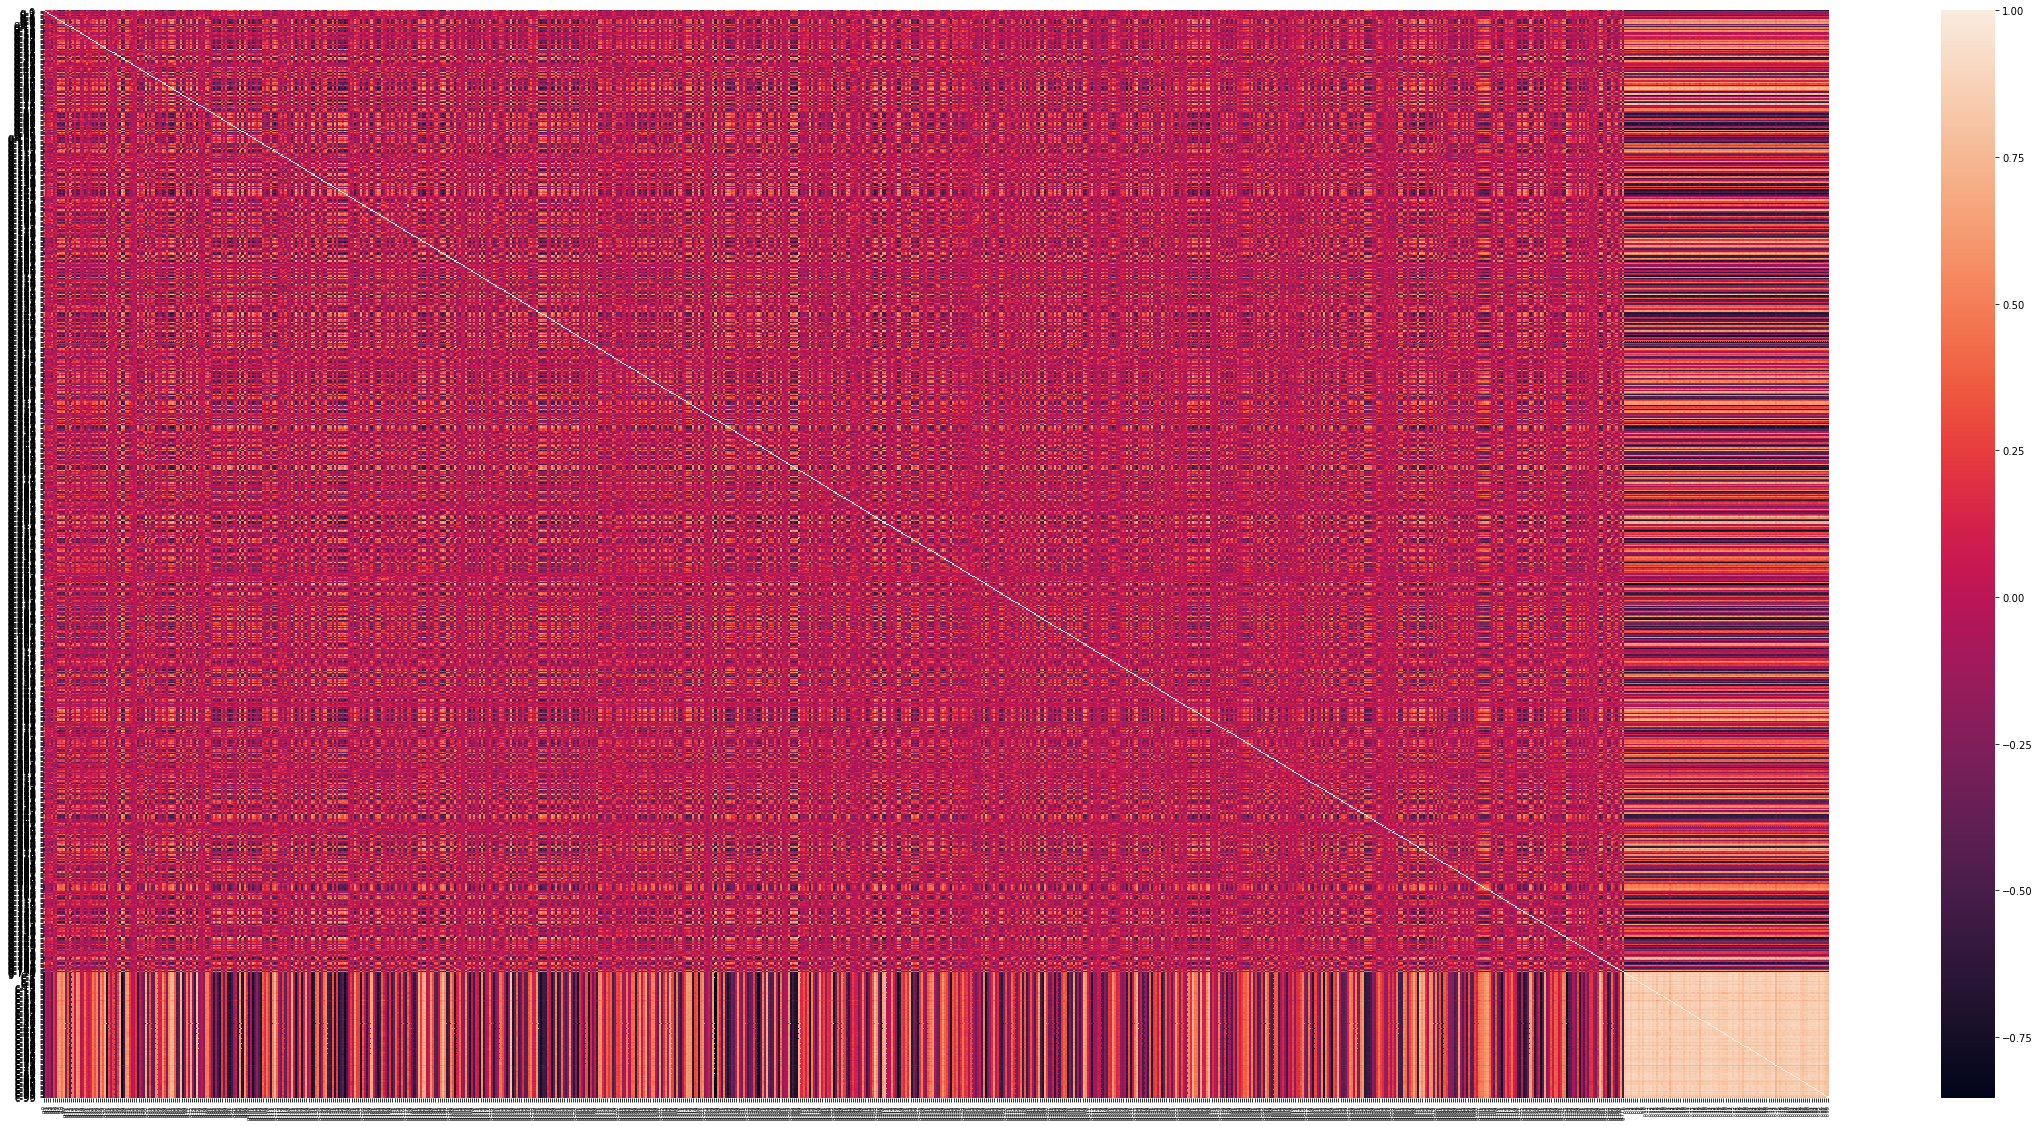

In [82]:
plt.figure(figsize=(40,20))
sns.heatmap(corr_mat, xticklabels = gene_feature_names + cell_feature_names, yticklabels=gene_feature_names + cell_feature_names)
plt.xticks(rotation = 90, fontsize = 5)
plt.show()

In [ ]:
# Feature Selection: Removing highly correlated continuos features
threshold = 0.6
columns = np.full((corr_mat.shape[0], ), True, dtype = bool)
for i in range(corr_mat.shape[0]):
  for j in range(i+1, corr_mat.shape[0]):
    if not columns[j]:
      continue
    if corr_mat[i,j] >= threshold or corr_mat[i,j] <= -threshold :
      if columns[j]:
        columns[j] = False

selected_features = [(gene_feature_names + cell_feature_names)[i] for i, j in enumerate(columns) if j==True]

In [81]:
len(selected_features)

530

### Standardizing selected features

Adding engineered  features and then standardizing all continuous features

In [13]:
train_data = train_data.select(other_feature_names + selected_features + target_names).join(max_gene_train_df, on = 'sig_id', how = 'inner').join(min_gene_train_df, on = 'sig_id', how = 'inner').join(max_cell_train_df, on = 'sig_id', how = 'inner').join(min_cell_train_df, on = 'sig_id', how = 'inner')
test_data = test_data.select(other_feature_names + selected_features + target_names).join(max_gene_test_df, on = 'sig_id', how = 'inner').join(min_gene_test_df, on = 'sig_id', how = 'inner').join(max_cell_test_df, on = 'sig_id', how = 'inner').join(min_cell_test_df, on = 'sig_id', how = 'inner')

In [ ]:
selected_features = selected_features + ['gene_max', 'gene_min', 'cell_max', 'cell_min']

In [14]:
va = VectorAssembler(inputCols = selected_features, outputCol = 'feature_vector')

train_data = va.transform(train_data)
test_data = va.transform(test_data)

ss = StandardScaler(withMean=True, inputCol = 'feature_vector', outputCol='features')
ss_model = ss.fit(train_data)

train_data = ss_model.transform(train_data).drop('feature_vector')
test_data = ss_model.transform(test_data).drop('feature_vector')

### Dimensionality Reduction (PCA)

In [15]:
k = 100
pca = PCA(k = k, inputCol='features', outputCol='pca_features')
pca_model = pca.fit(train_data)

In [94]:
cum_var = np.cumsum(pca_model.explainedVariance.toArray())

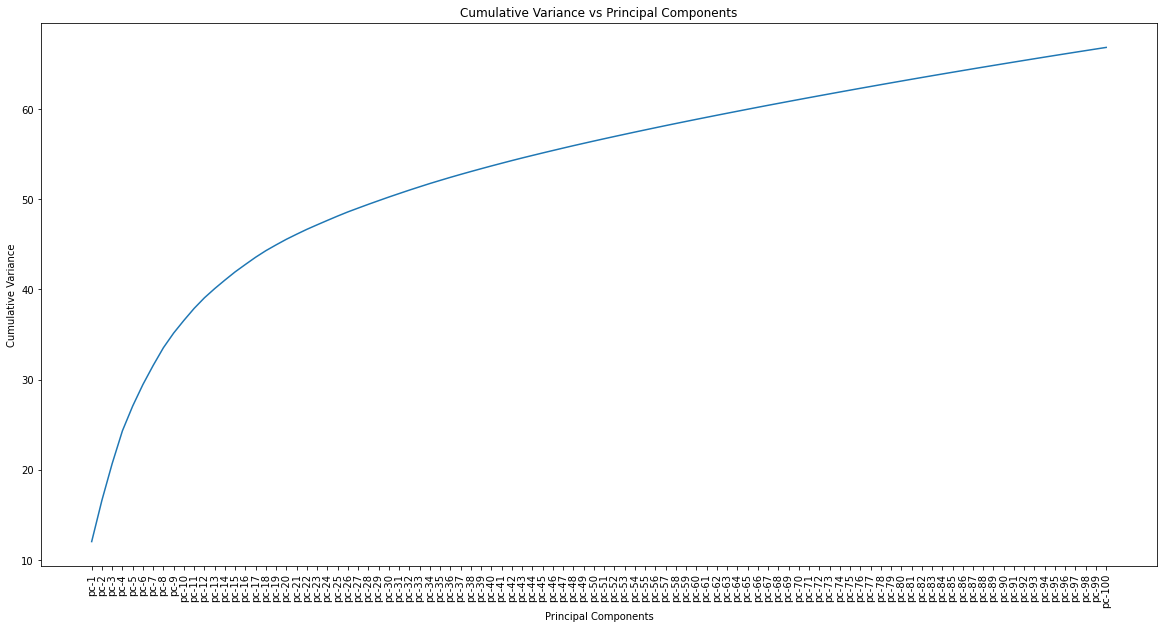

In [95]:
xlabels = ['pc-' + str(i+1) for i in range(k)]
plt.figure(figsize=(20,10))
plt.plot(xlabels, cum_var*100)
plt.xticks(rotation = 90)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Variance vs Principal Components')
plt.show()

In [17]:
train_data = pca_model.transform(train_data).drop('features')
test_data = pca_model.transform(test_data).drop('features')

In [18]:
train_data = train_data.select(['cp_time', 'cp_dose', 'pca_features'] + target_names)
test_data = test_data.select(['cp_time', 'cp_dose', 'pca_features'] + target_names)

### Traininig and Testing

In [19]:
def logloss(predictedProb, trueLabel):
    loss = (-trueLabel*np.log(predictedProb + 10e-15) - (1-trueLabel)*(np.log(1-predictedProb))).mean()
    return loss

In [22]:
loss = 0
losses = [] # List to store log loss error for individual target labels
untrained_labels = [] # List to store target labels for which model was not trained

for i, label in enumerate(target_names):
  
  X_train = train_data.select(['cp_time', 'cp_dose', 'pca_features'] + [label])
  X_test = test_data.select(['cp_time', 'cp_dose', 'pca_features'] + [label])
  one_count_train = X_train.filter(X_train[label] == 1).count()
  zero_count_train = X_train.filter(X_train[label] == 0).count()
  
#   If there are no activations for the label in the training dataset, no need to train the model (prediction would be all 0's)  
  if one_count_train == 0:
    untrained_labels.append(label)
    n = X_test.count()
    prob = np.array([0]*n)
    label = np.array(X_test.select(label).toPandas())[:,0]
    l = logloss(prob, label)
    print('No need to train the model. Will always output 0 for this label')
   
# Handling Data Imbalance: if number of samples with label 0 is more than twice the samples with label 1 - undersample
# majority class samples by half and oversample minority class samples so that counts are same 
    
  else:  
    factor = zero_count_train/one_count_train
    if factor>=2:
      zero_samples = X_train.filter(X_train[label]==0).sample(fraction = 0.5, withReplacement = False,  seed = 0) 
      one_samples = spark.createDataFrame(X_train.filter(X_train[label]==1).toPandas().sample(n = int(X_train.filter(X_train[label]==0).count()/2), replace = True,  random_state = 0))
      X_train = zero_samples.union(one_samples).orderBy(rand())
    
    va = VectorAssembler(inputCols = ['cp_time', 'cp_dose', 'pca_features'], outputCol = 'features')
    X_train = va.transform(X_train)
    X_test = va.transform(X_test)

    randomForest = RandomForestClassifier(labelCol = label)
    print('Training Random Forest')
    randomForestModel = randomForest.fit(X_train)
    print('Random Forest Trained')
    pred_df = randomForestModel.transform(X_test)
    evaluator = MulticlassClassificationEvaluator(labelCol=label, metricName='logLoss')
    l= evaluator.evaluate(pred_df)
    
  losses.append(l)
  print(f'Label Loss for {i}: {label} = {l}')
  loss+=l
  print(f'Hamming Loss after {i}: {label} = {loss/(i+1)}')
  d = {'losses': losses, 'untrained_labels': untrained_labels }
  f = open('data.pkl', 'wb')
  pickle.dump(d, f)
  f.close()  
  print('################################')
  X_train.unpersist()
  X_test.unpersist()
  pred_df.unpersist()  

Training Random Forest
Random Forest Trained
Label Loss for 0: 5-alpha_reductase_inhibitor = 0.10715911930171602
Hamming Loss after 0: 5-alpha_reductase_inhibitor = 0.10715911930171602
################################
Training Random Forest
Random Forest Trained
Label Loss for 1: 11-beta-hsd1_inhibitor = 0.1403045511826906
Hamming Loss after 1: 11-beta-hsd1_inhibitor = 0.12373183524220333
################################
Training Random Forest
Random Forest Trained
Label Loss for 2: acat_inhibitor = 0.2669429300151952
Hamming Loss after 2: acat_inhibitor = 0.17146886683320062
################################
Training Random Forest
Random Forest Trained
Label Loss for 3: acetylcholine_receptor_agonist = 0.5282263799139088
Hamming Loss after 3: acetylcholine_receptor_agonist = 0.26065824510337765
################################
Training Random Forest
Random Forest Trained
Label Loss for 4: acetylcholine_receptor_antagonist = 0.5721494145861349
Hamming Loss after 4: acetylcholine_recepto

Training Random Forest
Random Forest Trained
Label Loss for 40: bacterial_30s_ribosomal_subunit_inhibitor = 0.367216762381752
Hamming Loss after 40: bacterial_30s_ribosomal_subunit_inhibitor = 0.2494108453008607
################################
Training Random Forest
Random Forest Trained
Label Loss for 41: bacterial_50s_ribosomal_subunit_inhibitor = 0.3960724184346552
Hamming Loss after 41: bacterial_50s_ribosomal_subunit_inhibitor = 0.252902787518332
################################
Training Random Forest
Random Forest Trained
Label Loss for 42: bacterial_antifolate = 0.29930160671567213
Hamming Loss after 42: bacterial_antifolate = 0.25398182982524686
################################
Training Random Forest
Random Forest Trained
Label Loss for 43: bacterial_cell_wall_synthesis_inhibitor = 0.5525159872204527
Hamming Loss after 43: bacterial_cell_wall_synthesis_inhibitor = 0.2607666970387743
################################
Training Random Forest
Random Forest Trained
Label Loss for 44

Training Random Forest
Random Forest Trained
Label Loss for 79: dopamine_receptor_antagonist = 0.6025413804585367
Hamming Loss after 79: dopamine_receptor_antagonist = 0.2731789622320181
################################
Training Random Forest
Random Forest Trained
Label Loss for 80: egfr_inhibitor = 0.3196729880539837
Hamming Loss after 80: egfr_inhibitor = 0.27375296255080783
################################
Training Random Forest
Random Forest Trained
Label Loss for 81: elastase_inhibitor = 0.02450893651271837
Hamming Loss after 81: elastase_inhibitor = 0.27071340125766036
################################
Training Random Forest
Random Forest Trained
Label Loss for 82: erbb2_inhibitor = 0.00019616347672612948
Hamming Loss after 82: erbb2_inhibitor = 0.26745415742897444
################################
Training Random Forest
Random Forest Trained
Label Loss for 83: estrogen_receptor_agonist = 0.5198604195732073
Hamming Loss after 83: estrogen_receptor_agonist = 0.27045899388307243
####

Training Random Forest
Random Forest Trained
Label Loss for 118: jak_inhibitor = 0.2749977195504809
Hamming Loss after 118: jak_inhibitor = 0.27074255812620285
################################
Training Random Forest
Random Forest Trained
Label Loss for 119: kit_inhibitor = 0.402072913847188
Hamming Loss after 119: kit_inhibitor = 0.271836977757211
################################
Training Random Forest
Random Forest Trained
Label Loss for 120: laxative = 0.0464265461119587
Hamming Loss after 120: laxative = 0.2699740816279114
################################
Training Random Forest
Random Forest Trained
Label Loss for 121: leukotriene_inhibitor = 0.018964688676843755
Hamming Loss after 121: leukotriene_inhibitor = 0.2679166275873289
################################
Training Random Forest
Random Forest Trained
Label Loss for 122: leukotriene_receptor_antagonist = 0.4208586034493984
Hamming Loss after 122: leukotriene_receptor_antagonist = 0.2691600582853945
##############################

Training Random Forest
Random Forest Trained
Label Loss for 157: ppar_receptor_agonist = 0.4202010880111471
Hamming Loss after 157: ppar_receptor_agonist = 0.2630210132264787
################################
Training Random Forest
Random Forest Trained
Label Loss for 158: ppar_receptor_antagonist = 0.250598474582613
Hamming Loss after 158: ppar_receptor_antagonist = 0.2629428840526179
################################
Training Random Forest
Random Forest Trained
Label Loss for 159: progesterone_receptor_agonist = 0.41933169370027673
Hamming Loss after 159: progesterone_receptor_agonist = 0.2639203141129158
################################
Training Random Forest
Random Forest Trained
Label Loss for 160: progesterone_receptor_antagonist = 0.13118454216381917
Hamming Loss after 160: progesterone_receptor_antagonist = 0.2630958683244121
################################
Training Random Forest
Random Forest Trained
Label Loss for 161: prostaglandin_inhibitor = 0.31600936355857834
Hamming Loss

Training Random Forest
Random Forest Trained
Label Loss for 196: tropomyosin_receptor_kinase_inhibitor = 0.01290515975627592
Hamming Loss after 196: tropomyosin_receptor_kinase_inhibitor = 0.2573584519921661
################################
Training Random Forest
Random Forest Trained
Label Loss for 197: trpv_agonist = 0.16050757973451865
Hamming Loss after 197: trpv_agonist = 0.25686930617268305
################################
Training Random Forest
Random Forest Trained
Label Loss for 198: trpv_antagonist = 0.3591773193012848
Hamming Loss after 198: trpv_antagonist = 0.2573834167914197
################################
Training Random Forest
Random Forest Trained
Label Loss for 199: tubulin_inhibitor = 0.211726730016495
Hamming Loss after 199: tubulin_inhibitor = 0.2571551333575451
################################
Training Random Forest
Random Forest Trained
Label Loss for 200: tyrosine_kinase_inhibitor = 0.3779182958753258
Hamming Loss after 200: tyrosine_kinase_inhibitor = 0.257755

In [24]:
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

In [71]:
len(data['losses'])

206

In [27]:
data['untrained_labels']

[]

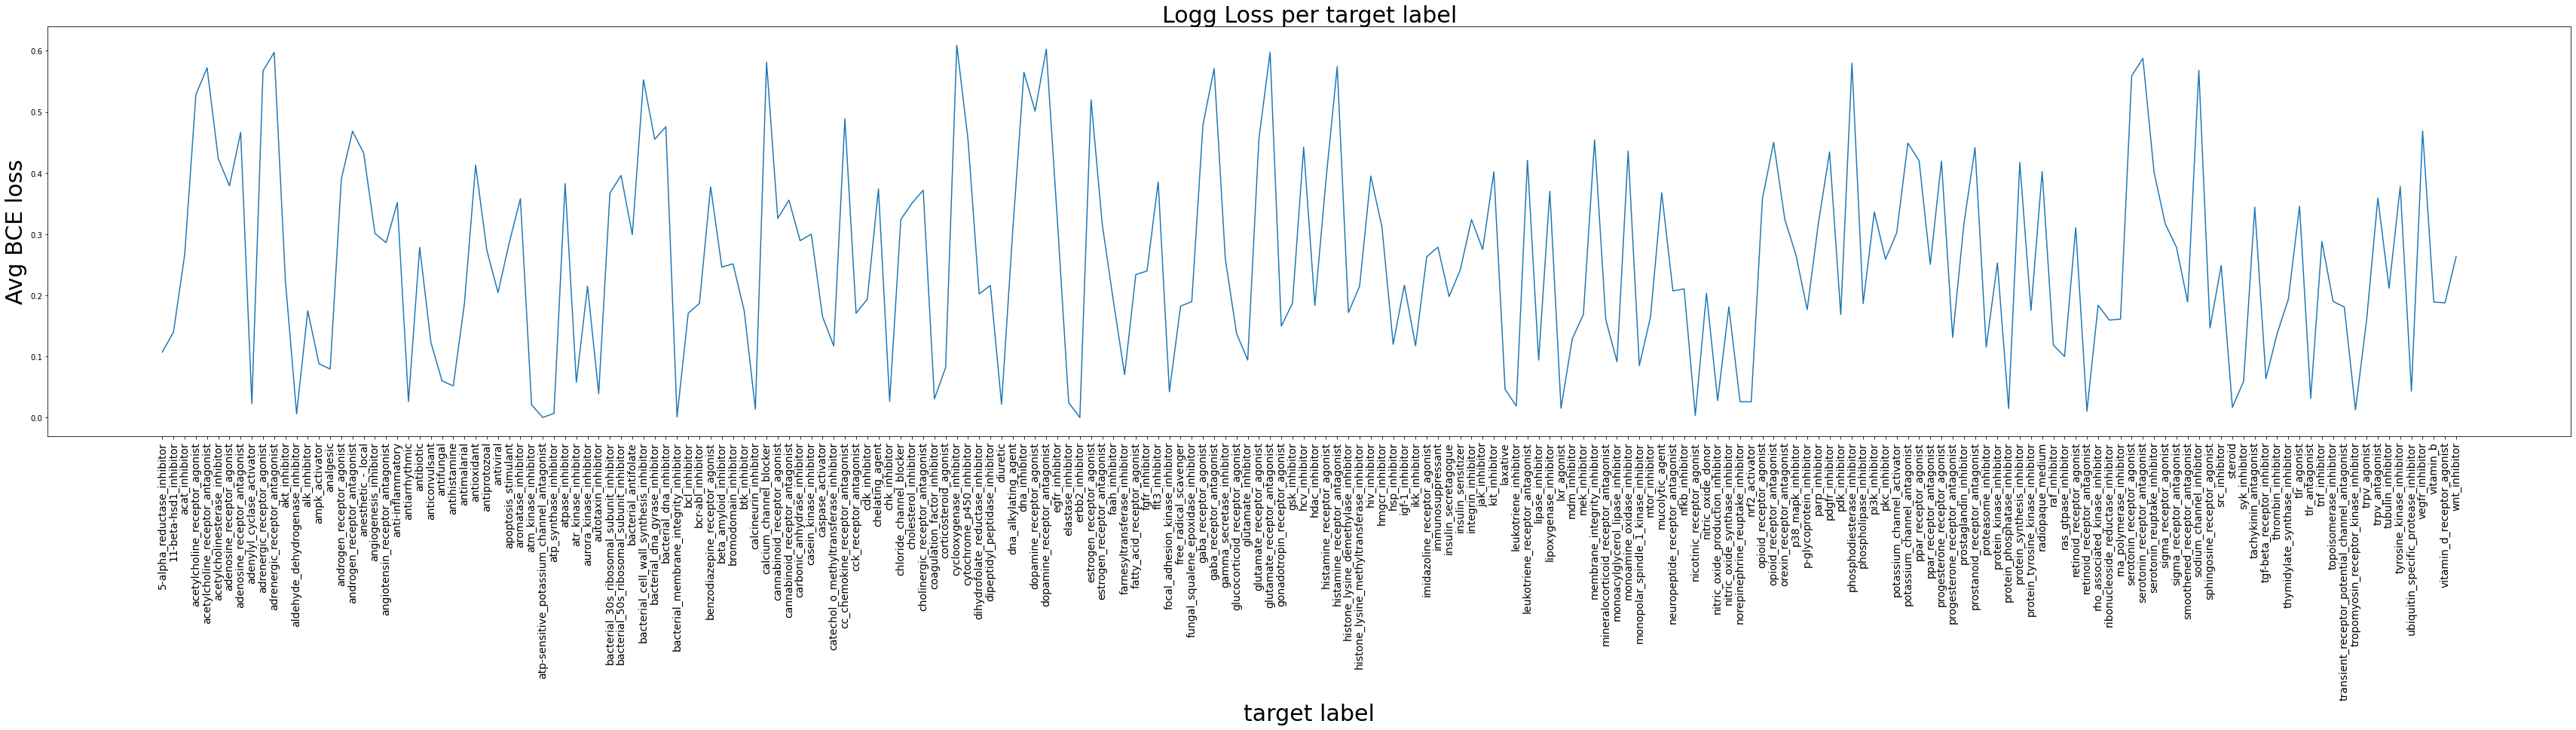

In [57]:
plt.figure(figsize = (60,10))
plt.plot(target_names, data['losses'])
plt.title('Logg Loss per target label', fontsize = 30)
plt.xlabel('target label', fontsize=30)
plt.ylabel('Avg BCE loss', fontsize = 30)
plt.xticks(rotation = 90, fontsize = 14)
plt.show()

In [66]:
def sum1(l):
    s = 0
    for i in l:
        s+=i
    return s

In [68]:
hamming_loss = [sum1(data['losses'][:i+1])/(i+1) for i in range(len(data['losses']))]

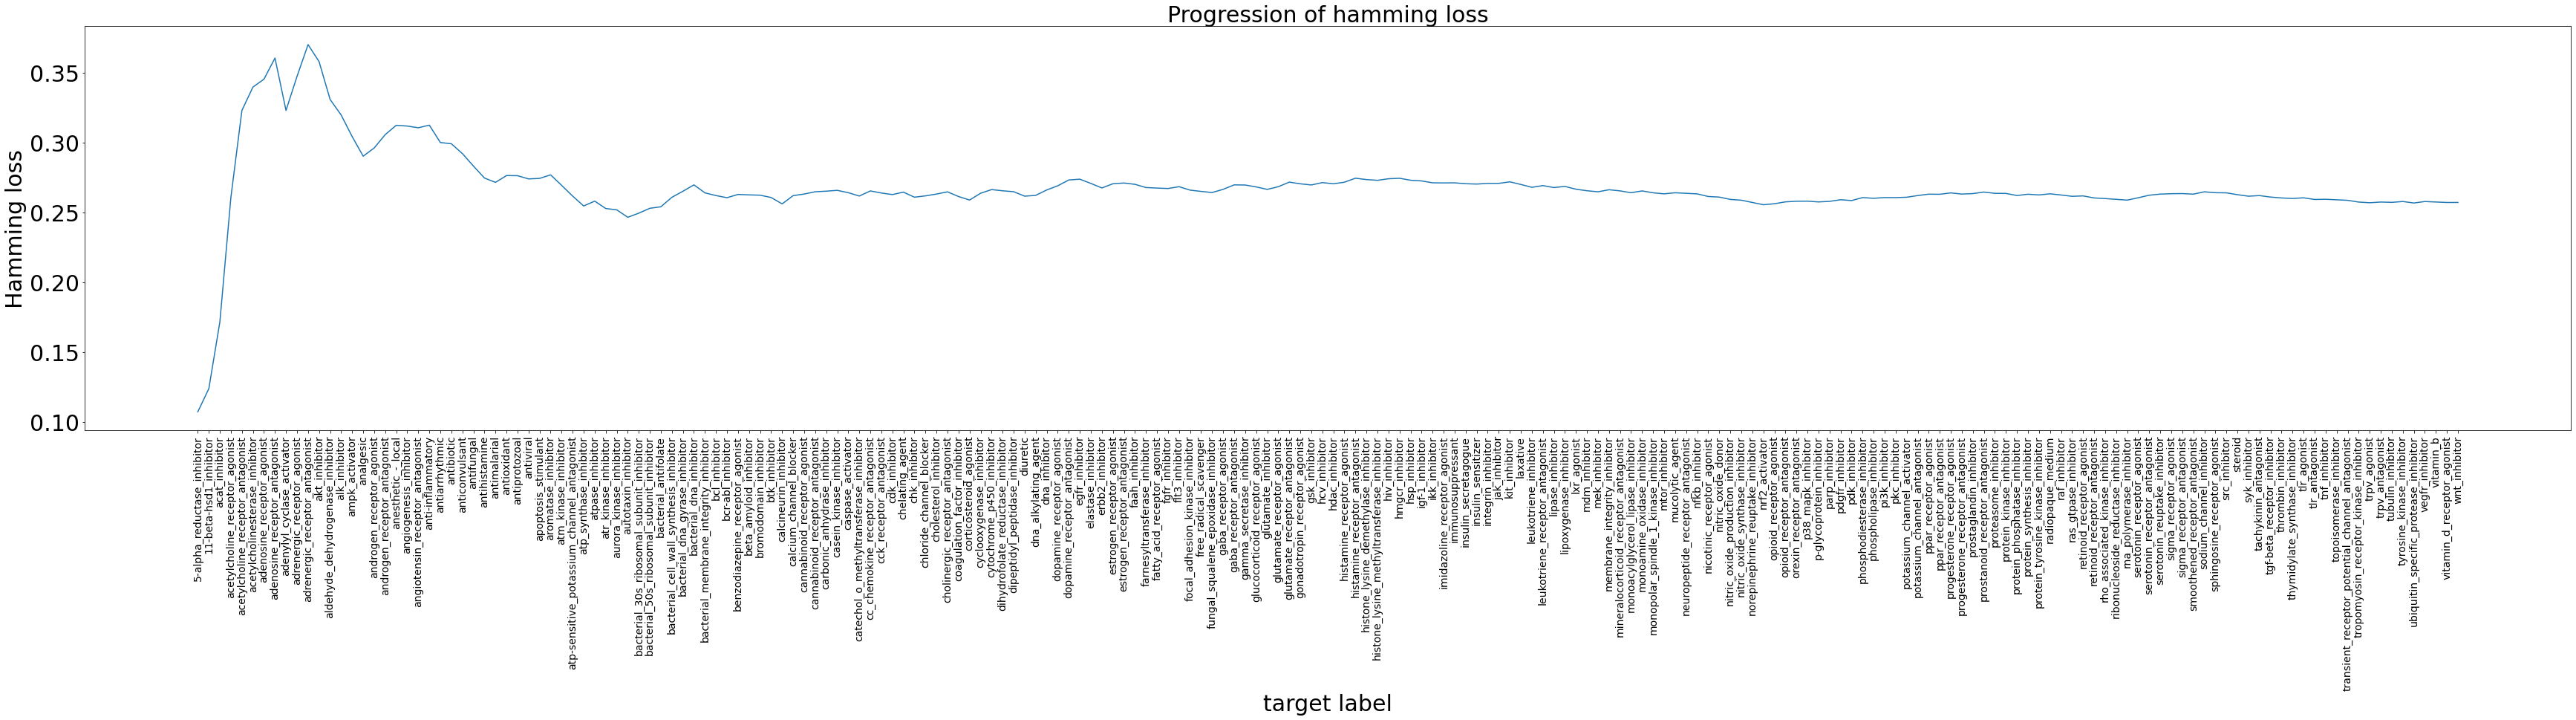

In [89]:
plt.figure(figsize = (60,10))
plt.plot(target_names, hamming_loss)
plt.title('Progression of hamming loss', fontsize = 30)
plt.xlabel('target label', fontsize=30)
plt.ylabel('Hamming loss', fontsize = 30)
plt.xticks(rotation = 90, fontsize = 14)
plt.yticks(fontsize = 30)
plt.show()

In [91]:
# Storing some info about training dynamics

data1 = data

In [103]:
data1['train_data'] = train_data.toPandas()
data1['test_data'] = test_data.toPandas()
data1['hamming_loss'] = hamming_loss
data1['variance'] = pca_model.explainedVariance.toArray()
data1['cumulative_variance'] = cum_var
data1['correlation_matrix'] = corr_mat
data1['selected_features'] = selected_features

In [104]:
with open('data.pkl', 'wb') as f:
    pickle.dump(data1, f)
